# Data science with Python and Netezza Performance Server

After the release of _Netezza Performance Server on Cloud Pak for Data_ (Netezza on Cloud) and _Netezza Performance Server on Cloud Pak for Data System_ (Netezza on prem) the next step in the modernization of Netezza is the ability to couple Netezza's in database analytics with Python's data science and visualization capabilities. 

With the release of [nzpy](https://pypi.org/project/nzpy/) you can connect to and work with Netezza on Cloud and Netezza on prem from any OS that support python. It even unlocks the ability to stream data directly to and from the Netezza system without any other software or drivers.

Lets look at two parts 

- First part will cover programming basics with nzpy
- The second will put everything together and actually go through a simple data science use case


## Nzpy programming basics

`nzpy` is a pure python driver implementation of the [Python DBAPI 2.0](https://www.python.org/dev/peps/pep-0249/DBApi) and so apart from a `pip install` there is no other pre-requisite.


### Connecting to the database 

The connection only requires the hostname of the Netezza 

In [14]:
import nzpy
import os

# assume NZ_USER, NZ_PASSWORD, NZ_DATABASE and NZ_HOST are set
con = nzpy.connect(user=os.environ["NZ_USER"], password=os.environ["NZ_PASSWORD"], host=os.environ["NZ_HOST"],
                   database=os.environ["NZ_DATABASE"], port=5480)

The `con` is a Python DBAPI [Connection](https://www.python.org/dev/peps/pep-0249/#connection-objects) that lets one interact with the Netezza database using its [Cursor](https://www.python.org/dev/peps/pep-0249/#cursor-objects) 

### Working with Netezza database 

The `con` and `con.cursor()` objects can be used to interact with the Netezza database. [pandas.Dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) can be used for quick result visualization in addition to its main purpose as the foundation of data science.  For example

In [3]:
import pandas as pd
result = pd.read_sql_query("select database, owner, createdate from _v_database where database like ^?^", con,
                              params=('tpc%',))
# make result column names human friendly
result.columns = [c.decode().lower() for c in result.columns]
result

,database,owner,createdate
0,TPC,ADMIN,2020-10-12 13:34:55
1,TPCH,ADMIN,2020-10-13 19:09:48
2,TPCQ,ADMIN,2020-10-12 18:34:12


`nzpy` also supports streaming data loads and unloads. There are quite a few variations we can do here. 

#### Load or unload regular flat files 

Unloading data to local files use streaming transient external table wiht `REMOTESOURCE 'python'` option like this.

In [4]:
with con.cursor() as cursor:
    cursor.execute('''
      create external table '/tmp/orders.csv'
        using (
            delim '|' 
            remotesource 'python'
            includeheader yes
        ) as select * from tpch..orders limit 20''')    
pd.read_csv('/tmp/orders.csv', delimiter='|')

,O_ORDERKEY,O_CUSTKEY,O_ORDERSTATUS,O_TOTALPRICE,O_ORDERDATE,O_ORDERPRIORITY,O_CLERK,O_SHIPPRIORITY,O_COMMENT
0,81696,42518,F,234702.52,1994-04-05,2-HIGH,Clerk#000000065,0,furiously regular packages are according to th...
1,81700,46552,F,68160.48,1992-05-13,5-LOW,Clerk#000000215,0,quickly bold dependencies after the special pa...
2,81728,4279,O,58585.08,1995-03-08,4-NOT SPECIFIED,Clerk#000000233,0,"ironic instructions sleep slyly. pending, fina..."
3,81732,46277,F,130629.61,1992-07-13,1-URGENT,Clerk#000000230,0,bold excuses wake among the regularly final pack
4,3,123314,F,193846.25,1993-10-14,5-LOW,Clerk#000000955,0,deposits alongside of the dependencies are slo...
5,7,39136,O,252004.18,1996-01-10,2-HIGH,Clerk#000000470,0,"ironic, regular deposits are. ironic foxes sl"
6,35,127588,O,253724.56,1995-10-23,4-NOT SPECIFIED,Clerk#000000259,0,fluffily regular pinto beans
7,39,81763,O,341734.47,1996-09-20,3-MEDIUM,Clerk#000000659,0,furiously unusual pinto beans above the furiou...
8,67,56614,O,169405.01,1996-12-19,4-NOT SPECIFIED,Clerk#000000547,0,"regular, bold foxes across the even requests d..."
9,71,3373,O,276992.74,1998-01-24,4-NOT SPECIFIED,Clerk#000000271,0,furiously ironic dolphins sleep slyly. careful...


The same works in reverse to load local files 

In [5]:
with con.cursor() as cursor:
    cursor.execute('''
        insert into tpch..orders
            select * from external '/tmp/orders.csv'
                using (
                    delim '|' 
                    remotesource 'python'
                    skiprows 1)''')
    print(f"{cursor.rowcount} rows inserted")
    # cursor.rowcount will report the number of rows loaded

20 rows inserted


#### Loading from other data sources

Data sources, like external servers, github etc can be fit into this model by streaming data from the source through the python application itself. The python using `nzpy` can read data from external sources and connect that directly to `nzpy` pipe via a named pipe. 

_(Note: The named pipe method below works seamlessly on Linux and Mac. For windows win32pipe module can be used to achieve the same)_

Creating a pipe for all data streaming loads lets one have a thread that can push data to this pipe. The other end is connected to Netezza via an external table.


In [6]:
import pathlib
datapipe = pathlib.Path("/tmp/datapipe")

def create_datapipe():
    global datapipe
    if datapipe.exists():
        print(f"Cleaning prior {datapipe}")
        datapipe.unlink()
    
    print(f"Initializing fifo", end='..')
    os.mkfifo(datapipe)
    print('Done')

The `requests` module coupled with `shutil.copyobject` can be used to actually stream rather than spool data. Here's an example of streaming data that is obtained as gzip'd from github

In [7]:
import requests, shutil, subprocess, gzip

def load_published_dataset(ds):
    with open(datapipe, "wb") as pipe:
        with requests.get(ds, stream=True) as r:
            with gzip.GzipFile(fileobj=r.raw) as unzip:
                shutil.copyfileobj(unzip, pipe)


Connecting the two together, and creating an external table over the named pipe will like this - 

_(Note: the pipe is put in a separate thread so that nzpy doesn't block the data stream)_

The `Cursor.rowcount` attribute will report the number of rows loaded

In [9]:
import threading

create_datapipe()
if datapipe.exists() and datapipe.is_fifo():
    print("Pipe ready")

source = 'https://raw.githubusercontent.com/ibm-watson-data-lab/open-data/master/cars/cars.csv'
streamer = threading.Thread(target=load_published_dataset, args=(source,))
streamer.start()

with con.cursor() as cursor:                            
    cursor.execute(f''' 
        insert into cars select * from external '{datapipe}' 
            using (
                delim ','
                remotesource 'python'
                skiprows 1  -- skip the header
            )''')
    print(f"{cursor.rowcount} rows inserted")
    
streamer.join()



Cleaning prior /tmp/datapipe
Initializing fifo..Done
Pipe ready
406 rows inserted


Doing it in revserse and specifying a file instead of named pipe will unload the data. `pandas.Dataframe` can be used to directly read the output of a query and then do further analytics on it. 

## A real life example

In this example lets use Python and Netezza Performance Server, to load and analyze the data on [Australian temperatures and rainfall published publically](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-01-07/readme.md) 

The best practices are 

- Load data into Netezza 
- Do as most of the filtering, transformation and analytics in database
- Do the last step of visualizing and final analytics by extracting the smaller result of the above step in Python

### Step 1 - Dataset

Lets look at the dataset. For the first go around, setup the tables. The data here represents the [Australian weather station temperature and rainfall data as of Jan 1 2020](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-01-07/readme.md) 

There are two tables 

**temperature.csv**

|column    |type     |description |
|:-----------|:---------|:-----------|
|city_name   |VARCHAR(20) | City Name|
|date        |DATE    | Date |
|temperature |NUMERIC(8,3)    | Temperature in Celsius |
|temp_type   |VARCHAR(10) | Temperature type (min/max daily) |
|site_name   |VARCHAR(30) | Actual site/weather station|

**rainfall.csv**

|column     |type     |description |
|:------------|:---------|:-----------|
|station_code |INT | Station Code |
|city_name    |VARCHAR(20) | City Name |
|year         |INT    | Year |
|month        |INT  | Month |
|day          |INT | Day |
|rainfall     |NUMERIC(8,3)    | rainfall in millimeters|
|period       |INT    | how many days was it collected across |
|quality      |VARCHAR(5) | Certified quality or not |
|lat          |NUMERIC(5,2)    | latitude |
|long         |NUMERIC(5,2)    | longitude |
|station_name |VARCHAR(30) | Station Name |


### Step 2 - Setup the tables

In [10]:
with con.cursor() as cursor:
    # find which of the tables already exist
    existing = { table[0] for table in cursor.execute("select lower(tablename) from _v_table where lower(tablename) in (?, ?)",
                                                 ("rainfall", "temperature")).fetchall() }
    if 'temperature' not in existing:
        # create only if they don't
        cursor.execute('''
        create table temperature (
            city_name     VARCHAR(20),
            date          DATE,
            temperature   NUMERIC(8,3),
            temp_type     VARCHAR(10),
            site_name     VARCHAR(30)
        ) distribute on (city_name)
        ''')
        print("Table temperature created")
        
    if 'rainfall' not in existing:
        cursor.execute('''
        create table rainfall (
            station_code  INT,
            city_name     VARCHAR(20),
            year          INT,
            month         INT,
            day           INT,
            rainfall      NUMERIC(8,3),
            period        INT,
            quality       VARCHAR(5),
            lat           NUMERIC(5,2),
            long          NUMERIC(5,2),
            station_name  VARCHAR(100)
        ) distribute on (city_name, station_code)
        ''')
        print("Table rainfall created")

Now stream and load both tables 

In [11]:
create_datapipe()

rainfall = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-07/rainfall.csv"
temperature = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-07/temperature.csv"

loader = threading.Thread(target=load_published_dataset, args=(rainfall,))
loader.start()

with con.cursor() as cursor:
    print("Loading data", end=".. ")
    result = cursor.execute(f'''INSERT INTO rainfall SELECT * FROM EXTERNAL '{datapipe}'
                                USING (
                                    DELIMITER ','
                                    REMOTESOURCE 'python'
                                    NULLVALUE 'NA'
                                    SKIPROWS 1)''')
    print(f"{cursor.rowcount} rows inserted")
    
loader.join()

Cleaning prior /tmp/datapipe
Initializing fifo..Done
Loading data.. 179273 rows inserted


In [15]:
create_datapipe()
temperature = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-07/temperature.csv"

loader = threading.Thread(target=load_published_dataset, args=(temperature,))
loader.start()

with con.cursor() as cursor:
    print("Loading data", end=".. ")
    result = cursor.execute(f'''INSERT INTO temperature SELECT * FROM EXTERNAL '{datapipe}'
                                USING (
                                    DELIMITER ','
                                    REMOTESOURCE 'python'
                                    NULLVALUE 'NA'
                                    SKIPROWS 1)''')
    print(f"{cursor.rowcount} rows inserted")
    
loader.join()

Cleaning prior /tmp/datapipe
Initializing fifo..Done
Loading data.. 528278 rows inserted


### Step - 3 Analyze the data

First analyze the data in database by grouping the temperatures across months and decades to reduce the dataset. After that visualization and further analytics can be done easily in python

In [17]:
df = pd.read_sql('''
    select extract(decade from date) * 10 as decade,
           extract(month from date) as month,
           city_name,
           avg(temperature) as avg
        from temperature
        where city_name in ('SYDNEY', 'MELBOURNE')
        group by month, decade, city_name
        order by month
 ''', con)

df.columns = [c.decode().lower() for c in df.columns]
df.decade = df.decade.astype(int)
df.avg = df.avg.astype(float)
df.month = df.month.astype(int)
df

,decade,month,city_name,avg
0,1910,1,MELBOURNE,19.161613
1,1910,1,SYDNEY,23.140777
2,1920,1,MELBOURNE,18.792419
3,1920,1,SYDNEY,22.192581
4,1930,1,MELBOURNE,19.118710
...,...,...,...,...
259,1990,12,SYDNEY,21.864194
260,2000,12,MELBOURNE,19.038871
261,2010,12,MELBOURNE,19.754480
262,2000,12,SYDNEY,22.285737


Now we can combine `DataFrame` with `ggplot` too see how average temperatures for two cities across the year stack up across all decades for the last 100 years

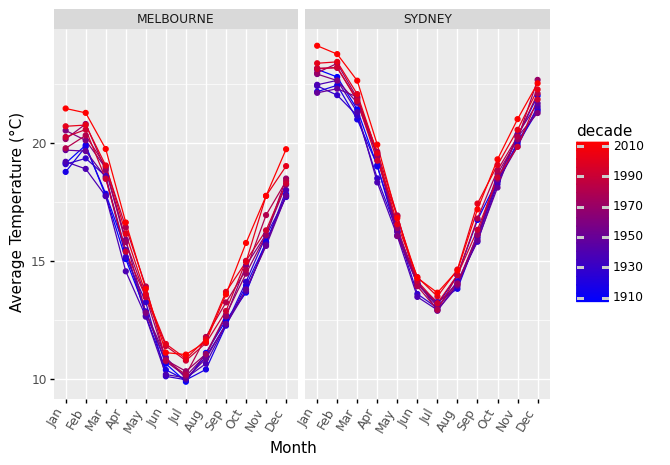

<ggplot: (319384137)>

In [18]:
import matplotlib, calendar
from plotnine import *
%matplotlib inline

( ggplot(df, aes(x='month', y='avg', group='decade', color='decade')) + geom_line() + geom_point() + 
  labs(y = "Average Temperature (°C)", x = "Month") + facet_wrap('city_name') +
   scale_color_gradient(low="blue", high="red") + 
   scale_x_discrete(labels=list(calendar.month_abbr[1:]), limits=range(12)) + 
   theme(axis_text_x=element_text(rotation=60, hjust=1))
)